# Kalorimetrie Küchentischversuch - Newtonsches Abkühlungsgesetz
Author: Keanu Engel

Datum: 18.11.2023

Gruppe: 12

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu diesem Versuch.

Wie kann ich die thermischen Verluste eines heißen Gefäßes ausrechnen, bzw. wie hoch sind diese? Mit welcher Rate nimmt die Temperatur ab, bzw. wie hoch ist die Temperaturdifferenz zwischen Anfangs- und Endwert der Messung? Wie kann ich das Newtonsche Abkühlgesetz über die Temperaturänderung des Wassers einer Tasse an der Umgebung bestätigen? Wie kann ich die Transportkoeffizienten hierbei bestimmen?

## Versuchsaufbau und Durchführung

Beschreiben Sie den Versuchsaufbau und die Versuchsdurchführung. Machen Sie ein Bild von Ihrem Aufbau und nutzen Sie dieses mit zur Beschreibung.

Bei diesem Versuch wird eine Tasse mit heißem Wasser befüllt und dabei wird die Temperatur innerhalb der Tasse über eine Dauer von 10 Minuten gemessen, um zu quantifizieren, wie viel die Tasse an der Umgebung abkühlt, bzw. wie hoch die Temperaturdifferenz ist. Dafür wird ebenfalls ein Temperatursensor in genügendem Abstand zur Tasse plaziert, um die Umgebungstemperatur zu messen.


<img src="figures/Versuchsaufbau_Newton.jpg" width="800">

## Versuchsauswertung

In [79]:
import numpy as np
from matplotlib import pyplot as plt
# If you plan to write functions in another module,
# you can use importlib.reload(module) to reload the module
# at the beginning of each cell in order to make the latest
# changes take effect without restart the kernel.
import importlib

# Use FST-Style, if you don't like it, you can safely delete this line.
plt.style.use("FST.mplstyle")


### Newtonsches Abkühlungsgesetz

Hinweis: Nutzen Sie die Funktionen *get_ids_from_setup* und *get_json_entry* um auf Metadaten zuzugreifen. 

Sie sollten Ihr Programm zwischen TODO und DONE implementieren, und versuchen die Anweisung zu verfolgen. Das ist aber nicht erforderlich.


#### (i) Messdaten einlesen

Messdaten werden in das Notebook eingelesen.

In [80]:
# TODO: Define the path to hdf5 file, which containing experiment data for constant.

path = '/home/pi/calorimetry_home/data/newton/newton.h5'

# DONE #

In [81]:
# TODO: Read all experimental data and associated metadata from HDF5 files for data processing.
# HINT: You can find information about how to access to H5 Files in the README of your Repo.
import h5py

# Dictionary erstellen für die Daten aus der hdf5 Datei
data_sensors = {}

# hdf5 Datei als read only öffnen
with h5py.File(path, 'r') as file:

   # Raw Data abrufen
   raw_data = file['RawData']

   # Für alle Sensor UUids in RawData Temperatur und Timestamp auslesen und als Array speichern
   for sensor_uuids in raw_data:
            
            temperature_data = raw_data[sensor_uuids]['temperature']
            temperature = temperature_data[()]
       
            timestamp_data = raw_data[sensor_uuids]['timestamp']
            timestamp = timestamp_data[()]

            data_sensors[sensor_uuids] = {'temperature': temperature, 'timestamp': timestamp}

#print(data_sensors)
#print(timestamp)

# DONE #

#### (ii) Daten Semi–log ploten

Die Zeit und Differenz zwischen der heißen Flüssigkeit und der Umgebungstemperatur wird aufgezeichnet.

Die y-Achse (Temperaturdifferenz) ist auf logarithmisch eingestellt und die x-Achse (Zeit) verwendet eine normale Skalierung.

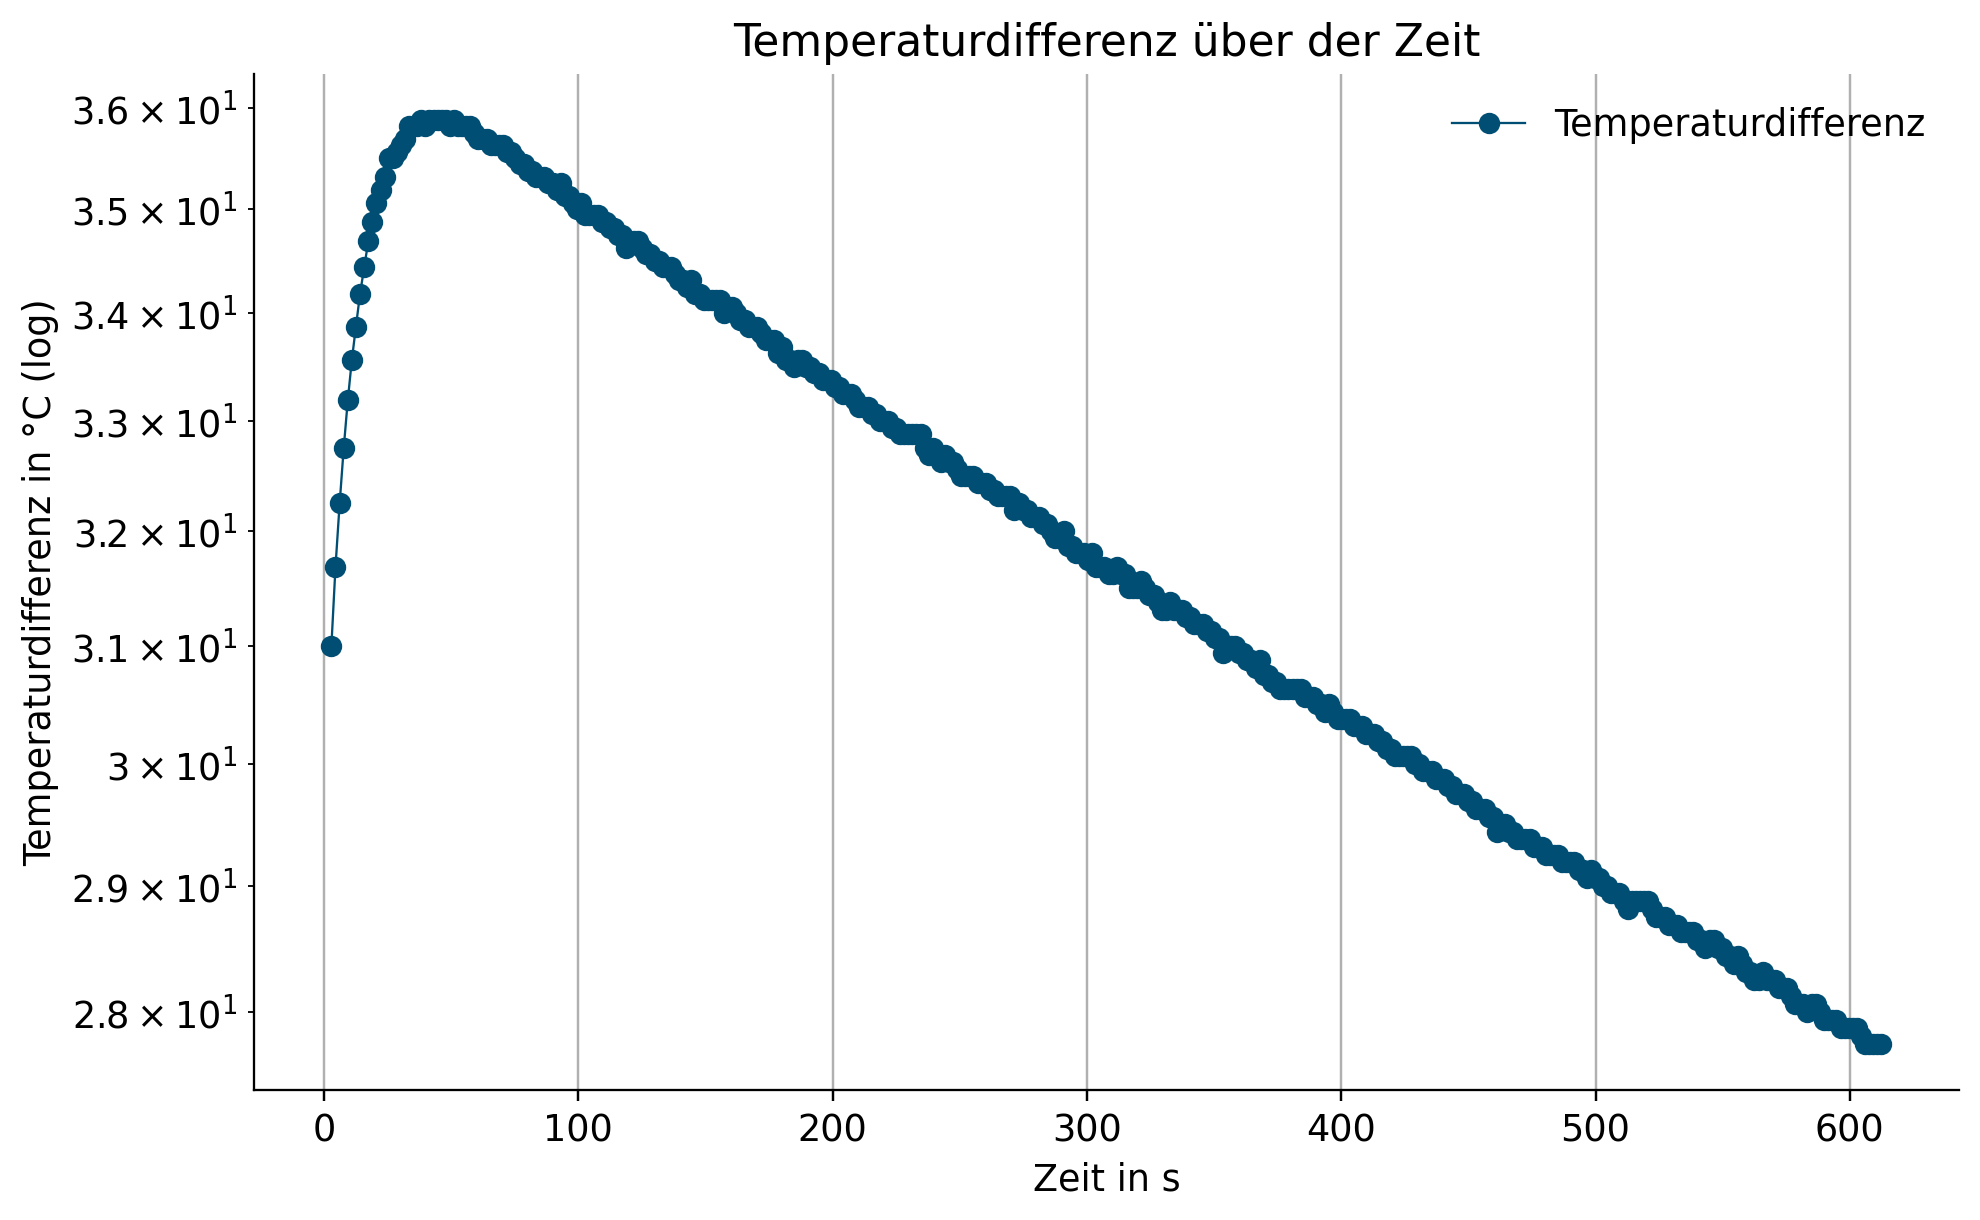

<Figure size 1471.8x1012 with 0 Axes>

In [82]:
# TODO: Use the temperature and time data for plotting
import matplotlib.pyplot as plt
import numpy as np

# Daten extrahieren
sensor1_uuid = '1ee82f6d-695a-695b-9b96-53b66f1fd36f'
sensor2_uuid = '1ee82fc3-53ee-6f2b-af66-fda31bc08fce'

sensor1_data = data_sensors[sensor1_uuid]
sensor2_data = data_sensors[sensor2_uuid]

time1 = sensor1_data['timestamp']
temperature1 = sensor1_data['temperature']

time2 = sensor2_data['timestamp']
temperature2 = sensor2_data['temperature']

# Liste der Temperaturen auf eine Länge bringen, damit damit weitergearbeitet werden kann
if len(temperature1) != len(temperature2):
    temperature1 = np.delete(temperature1,-1)
temperature_difference = temperature2-temperature1

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(time2, temperature_difference, label='Temperaturdifferenz', marker='o')

# Achsentitel und Diagrammtitel hinzufügen
plt.xlabel('Zeit in s')
plt.ylabel('Temperaturdifferenz in °C (log)')
plt.title('Temperaturdifferenz über der Zeit')

# Logarithmische Skala für die y-Achse
plt.yscale('log')

# Legende hinzufügen
plt.legend()

# Gitter hinzufügen
plt.grid(True)

# Schriftart festlegen
plt.rcParams['font.family'] = 'Arial'

# Diagramm anzeigen
plt.show()

# Pfad zum Speichern der Datei festlegen
file_path = '/home/pi/calorimetry_home/figures/Temperaturverlauf_Newton.svg'

# Speichern des Graphen als svg
plt.savefig(file_path)

#print(temperature2)

# DONE #

#### (iii) Koeffizient in Newtonschem Abkühlungsgesetz
Die `numpy.polyfit` Funktion ist zu verwenden, um den Koeffizienten $K$ zu bestimmen.
$$
T(t) - T_2 = (T_1 - T_2)e^{Kt}
$$
Dabei ist $T(t) - T_2$ der Verlauf der Temperaturdifferenz. Die Anfangstemperatur ist $T_1$, die Endtemperatur ist $T_2$.

In [83]:
# TODO: Determine coefficient in Newtonschen Abkühlungsgesetz

# Anfangstemperatur Wasser (nachdem es sich auf die höchste Temperatur angepasst hat)
# bei temperature[0] würde es sonst in der Vorraussagung ungewollte Abweichung geben 
highest_temp = np.argmax(temperature2)
T_1 = temperature2[highest_temp]

# Umgebungstemperatur 
T_2 = temperature1[0]

# Natürlicher Logarithmus von der Temperaturdifferenz
log_temperature_difference = np.log(temperature_difference)

# Koeffizient K mit numpy.polyfit bestimmen
coefficients=np.polyfit(timestamp, log_temperature_difference-np.log(T_1-T_2), 1)

# Extrahiere den Koeffizienten K
K = coefficients[0]

# Berechnung der vorrausgesagten Temperatur für die letze Temperatur 
t = timestamp[-1]
T_end = (T_1-T_2)*np.exp(K*t) + T_2

# gemessene Endtemperatur des Wassers in der Tasse nach der Zeit des Versuchs 
T_end_gemessen = temperature2[-1]

#print(T_1)
# DONE #

#### (iV) Ergebnis

In [84]:
# TODO: Print result

print('Der Koeffizient K im Newtonschen Abkühlungsgesetz ist: ', K)
print('Gemessene Temperatur am Ende des Versuchs: ' + str(T_end_gemessen) + '°C')
print('Vorrausgesagte Temperatur am Ende des Versuchs: ' + str(T_end) + '°C')

# DONE #

Der Koeffizient K im Newtonschen Abkühlungsgesetz ist:  -0.0004322260369076463
Gemessene Temperatur am Ende des Versuchs: 48.625°C
Vorrausgesagte Temperatur am Ende des Versuchs: 48.642000172423124°C


## Diskussion

Analysieren Sie Ihre Ergebnisse aus wissenschaflticher Sicht. Berücksichtigen Sie dabei Ihre oben genannte Forschungsfrage.
Können Sie das Newtonsche Abkühlungsgesetz bestätigen?

Anhand der geliferten Daten ist klar zu erkennen, dass mit diesem Versuch das Newtonsche Abkühlgesetz bestätigt worden ist. Die gemessene Temperatur am Ende des Versuchs liegt bei 48.63°C und die vorrausgesagte Temperatur am Ende des Versuch liegt bei 48.64°C, somit liegt hier nur eine Abweichung von 0.01°C vor. Das Wasser ist während dem Versuch von der maximalen Temperatur aus, bis zum Ende des Versuch insgesamt 8,375°C abgekühlt.

## Fazit
Ziehe Sie ein persönliches Fazit zum Versuch.

Während der Auswertung dieses Versuchs ist mir aufgefallen, dass ich den Sensor noch länger in dem heißen Wasser lassen muss, damit dieser die höchst Temperatur annimmt und nicht erst nach einer gewissen Zeit diese erreicht, da dies zu einer Abweichung in der Vorraussagung führen würde. Dies würde ich bei den nächsten Versuchen aufjedenfall anpassen, damit direkt mit dem Anfangswert gerechnet werden kann und dann auch bei dem Anfangswert, sehr gute Vorhersagen rauskommen. Außerdem habe ich durch diesen Veruch gesehen, dass die Vorraussage über das Newtonsche Abkühlgesetz sehr präzise funktioniert, was mich sehr überrascht hat, da hier gar nicht die Fläche des Wassers in der Berechnung mit einbezogen wurde, die an der Umgebung war.